# RNN for text classification and text generation
### Dr. Omri Allouche 2021. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/rnn_text_classification_generation/DL_rnn_text_classification_generation.ipynb)

In the first part of this exercise, we’ll continue our attempts to classify text using different network architectures. This time, we’ll try a LSTM. We'll use the Metrolyrics dataset we used in the previous exercise.  

You are encouraged to review the code in [this](https://github.com/prakashpandey9/Text-Classification-Pytorch) repo, that contains implementation of several deep learning architectures for text classification in PyTorch. If you face time limitations, you're welcome to adapt it to your needs instead of writing your own code from scratch.

In the second part of this exercise, you'll unleash the hidden creativity of your computer, by letting it generate Country songs (yeehaw!). You'll train a character-level RNN-based language model, and use it to generate new songs.


### Special Note
Our Deep Learning course was packed with both theory and practice. In a short time, you've got to learn the basics of deep learning theory and get hands-on experience training and using pretrained DL networks, while learning PyTorch.  
Past exercises required a lot of work, and hopefully gave you a sense of the challenges and difficulties one faces when using deep learning in the real world. While the investment you've made in the course so far is enormous, I strongly encourage you to take a stab at this exercise. 

DL networks for NLP are much shallower than those for image classification. It's possible to construct your own networks from scratch, and achieve nice results. While I hope the theoretical foundations of RNNs are clear after our class sessions, getting your hands dirty with their implementation in PyTorch allows you to set breakpoints, watch the dimensions of the different layers and components and get a much better understand of theory, in addition to code that might prove useful later for your own projects. 

I tried to provide references for all parts that walk you through a very similar task (actually, the same task on a different dataset). I expect this exercise to require much less of your time than previous exercises.

The exercise is aimed to help you get better understanding of the concepts. I am not looking for the optimal model performance, and don't look for extensive optimization of hyperparameters. The task we face in this exercise, namely the classification of the song’s genre from its text alone, is quite challenging, and we probably shouldn’t expect great results from our classifier. Don’t let this discourage you - not every task reaches an f1 score of 90%+. 

In fact, some of the reasons I chose this dataset is because it highlights some of the issues we face in machine learning models in the real world. Examples include:
- The classes are highly imbalanced - try to think how this affects the network learning
- Given the small amount of data for some classes, you might actually prefer to remove them from the dataset. How would you decide that?
- NLP tasks often involve preprocessing (lowercasing, tokenization, lemmatization, stopwords removal etc.). The decision on the actual preprocessing pipeline depends on the task, and is often influenced by our believes about the data and exploratory analysis of it. Thinking conciously about these questions helps you be a better data scientist
- Some songs contain no lyrics (for example, they just contain the text "instrumental"). Others include non-English characters. You'll often need to preprocess your data and make decisions as to what your network should actually get as input (think - how should you treat newline characters?)
- While model performance on this dataset are not amazing, we can try to answer interesting follow-up questions - which genres are more similar to each other and are often confused? Do genres become more similar through the years? ...

More issues will probably pop up while you're working on this task. If you face technical difficulties or find a step in the process that takes too long, please let me know. It would also be great if you share with the class code you wrote that speeds up some of the work (for example, a data loader class, a parsed dataset etc.)

## RNN for Text Classification
In this section you'll write a text classifier using LSTM, to determine the genre of a song based on its lyrics.  
The code needed for this section should be very similar to code you've written for the previous exercise, and use the same dataset.  

In [69]:
import pandas as pd
import nltk
nltk.download('stopwords')
import re
from gensim.models import word2vec
import torch
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import time
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# for cleaning text, removing stop words, and applying lemmatization and stemming

'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=False, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'([^a-zA-Z0-9])', ' ', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
# load file
songs = pd.read_parquet("https://raw.githubusercontent.com/omriallouche/ydata_deep_learning_2021/master/data/metrolyrics.parquet")

# create a list of generic stop words for the English vocabulary 
lst_stopwords = nltk.corpus.stopwords.words("english")

# clean lyrics
songs["clean_lyrics"] = (songs["lyrics"]).apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=False, 
          lst_stopwords=lst_stopwords))

# create list of lists of unigrams
corpus = songs["clean_lyrics"]
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

# Set parameters values
num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        

In [13]:
# Train a model with context size of 5

context = 5          # Context window size

# Initialize and train the model (this will take some time)
model_5 = word2vec.Word2Vec(lst_corpus, size=num_features, min_count = min_word_count, \
            window = context)

In [54]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [11]:
# a row for each song where each column is a word index, in order and without rare words
def get_song_vec_mat(tokenized_lyrics):
    songs_embeddings = torch.zeros((songs.shape[0], 128))

    for song_ind, song in tqdm(enumerate(tokenized_lyrics), position=0, leave=True):
        words_list = song.split()
        padded_X = np.zeros(128)
        i = 0

        for word in words_list:
          if i > 127:
            break

          if word in model_5.wv.vocab:
              padded_X[i] = model_5.wv.vocab[word].index + 1 # adding 1 because we are going to insert a 0 vector for padding at the start of the word2vec vectors
              i += 1

        songs_embeddings[song_ind,:] += padded_X

    return songs_embeddings

In [14]:
# create songs matrix
songs_mat = get_song_vec_mat(songs["clean_lyrics"])
songs_mat = songs_mat.long()

49976it [00:21, 2314.78it/s]


In [15]:
# For the embedding layer - taking the word2vec vectors and adding 0 vector at the start for padding
embed = np.copy(model_5.wv.vectors)
pad = np.zeros(300)
embed = np.vstack((pad, embed))
embed = torch.tensor(embed).float()

# create labels and split to train and test
labels = pd.Categorical(songs.genre.values).codes
labels_names = ['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock']
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(songs_mat, labels, test_size = 0.2)

In [48]:
# LSTM Multi Class classifier
class BiLSTM(nn.Module):
    
    def __init__(self, n_classes=5, pretrained_embedding=None, freeze_embedding=True, embed_dim = 300, vocab_size=None):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.2
        self.n_classes = n_classes

        # Embedding layer
        if pretrained_embedding is not None:
          self.max_features, self.embed_size = pretrained_embedding.shape
          self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=freeze_embedding, padding_idx=0)

        else:
          self.embed_size = embed_dim
          self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_size,
                                          padding_idx=0)
          
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [164]:
# Train and evaluate

n_epochs = 10
model = BiLSTM(pretrained_embedding=embed)
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()
batch_size=50
n_classes = 5

# Load train and test in CUDA Memory
x_train = torch.tensor(X_net_train, dtype=torch.long).cuda()
y_train = torch.tensor(y_net_train, dtype=torch.long).cuda()
x_cv = torch.tensor(X_net_test, dtype=torch.long).cuda()
y_cv = torch.tensor(y_net_test, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

best_accuracy = 0 # for keeping the best model

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),n_classes))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==y_net_test)/len(y_net_test)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
    
    # Track the best accuracy
    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
                
      # deepcopy the model and save predictions
      best_model_wts = copy.deepcopy(model.state_dict())
      best_preds = val_preds.copy()

print("\n")
print(f"Training complete! Best accuracy: {best_accuracy * 100:.0f}%.")

Epoch 1/10 	 loss=51.2741 	 val_loss=46.6381  	 val_acc=0.6156  	 time=8.06s
Epoch 2/10 	 loss=45.6295 	 val_loss=44.7718  	 val_acc=0.6376  	 time=7.99s
Epoch 3/10 	 loss=43.3369 	 val_loss=44.1937  	 val_acc=0.6466  	 time=7.96s
Epoch 4/10 	 loss=41.1240 	 val_loss=43.9460  	 val_acc=0.6440  	 time=8.02s
Epoch 5/10 	 loss=39.1086 	 val_loss=44.2691  	 val_acc=0.6483  	 time=7.98s
Epoch 6/10 	 loss=36.9995 	 val_loss=45.5130  	 val_acc=0.6447  	 time=7.95s
Epoch 7/10 	 loss=34.6272 	 val_loss=45.5679  	 val_acc=0.6423  	 time=8.15s
Epoch 8/10 	 loss=32.1385 	 val_loss=47.1913  	 val_acc=0.6388  	 time=8.03s
Epoch 9/10 	 loss=29.6855 	 val_loss=49.4881  	 val_acc=0.6365  	 time=7.96s
Epoch 10/10 	 loss=27.2604 	 val_loss=51.6188  	 val_acc=0.6287  	 time=7.92s


Training complete! Best accuracy: 65%.


In [62]:
def plot_confusion_matrix_net(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=-45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

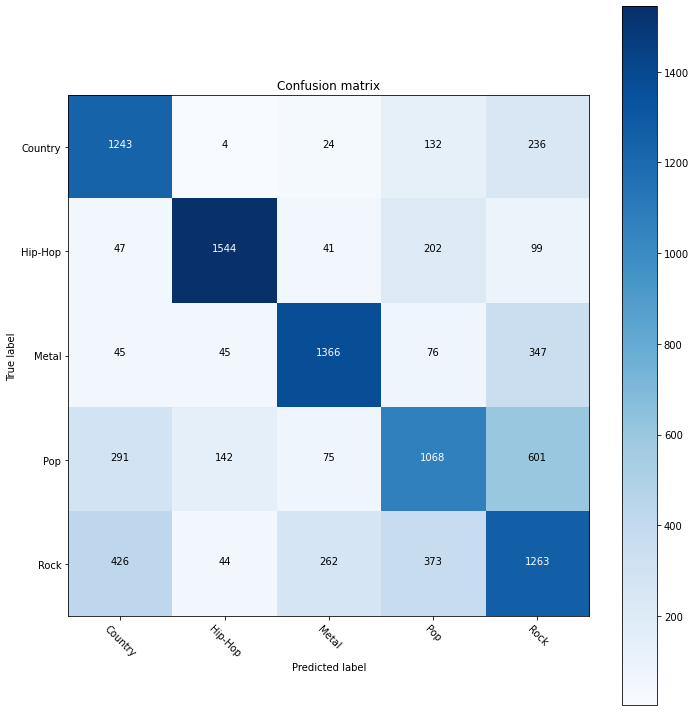

In [74]:
# Confusion matrix
y_pred = np.argmax(best_preds, axis=1)
confusion = confusion_matrix(y_net_test, y_pred)
plot_confusion_matrix_net(cm=confusion,classes=labels_names)

In [76]:
# Classification report
print(classification_report(y_net_test, y_pred, target_names=labels_names))

              precision    recall  f1-score   support

     Country       0.61      0.76      0.67      1639
     Hip-Hop       0.87      0.80      0.83      1933
       Metal       0.77      0.73      0.75      1879
         Pop       0.58      0.49      0.53      2177
        Rock       0.50      0.53      0.51      2368

    accuracy                           0.65      9996
   macro avg       0.66      0.66      0.66      9996
weighted avg       0.66      0.65      0.65      9996



## RNN for Text Generation
In this section, we'll use an LSTM to generate new songs. You can pick any genre you like, or just use all genres. You can even try to generate songs in the style of a certain artist - remember that the Metrolyrics dataset contains the author of each song. 

For this, we’ll first train a character-based language model. We’ve mostly discussed in class the usage of RNNs to predict the next word given past words, but as we’ve mentioned in class, RNNs can also be used to learn sequences of characters.

First, please go through the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) on generating family names. You can download a .py file or a jupyter notebook with the entire code of the tutorial. 

As a reminder of topics we've discussed in class, see Andrej Karpathy's popular blog post ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). You are also encouraged to view [this](https://gist.github.com/karpathy/d4dee566867f8291f086) vanilla implementation of a character-level RNN, written in numpy with just 100 lines of code, including the forward and backward passes.  

Other tutorials that might prove useful:
1. http://warmspringwinds.github.io/pytorch/rnns/2018/01/27/learning-to-generate-lyrics-and-music-with-recurrent-neural-networks/
1. https://github.com/mcleonard/pytorch-charRNN
1. https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

In [124]:
from torch.distributions import Categorical

In [105]:
# character-based language model
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())

In [165]:
data_path = 'output.txt'

# Hyperparameters
hidden_size = 512   # size of hidden state
seq_len = 100       # length of LSTM sequence
num_layers = 3      # num of layers in LSTM layer stack
lr = 0.002          # learning rate
epochs = 50         # max number of epochs
op_seq_len = 200    # total num of characters in output test sequence

In [166]:
# We will generate some valuable classics
hh_songs = songs.loc[songs['artist'] == 'backstreet-boys']

# load all songs to a file and reload it
with open(data_path, 'w') as f:
    for text in hh_songs['lyrics'].tolist():
        f.write(text + '\n')

data = open(data_path, 'r').read()
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 97483 characters, 77 unique


In [167]:
# char to index and index to char maps
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
    
# convert data from chars to indices
data = list(data)
for i, ch in enumerate(data):
  data[i] = char_to_ix[ch]
    
# data tensor on device
data = torch.tensor(data).to(device)
data = torch.unsqueeze(data, dim=1)
    
# model instance
rnn = RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
    
# training loop
for i_epoch in range(1, epochs+1):
        
  # random starting point (1st 100 chars) from data to begin
  data_ptr = np.random.randint(100)
  n = 0
  running_loss = 0
  hidden_state = None
        
  while True:
    input_seq = data[data_ptr : data_ptr+seq_len]
    target_seq = data[data_ptr+1 : data_ptr+seq_len+1]
            
    # forward pass
    output, hidden_state = rnn(input_seq, hidden_state)
            
    # compute loss
    loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
    running_loss += loss.item()
            
    # compute gradients and take optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
            
    # update the data pointer
    data_ptr += seq_len
    n +=1
            
    # if at end of data : break
    if data_ptr + seq_len + 1 > data_size:
      break
            
  # print loss and save weights after every epoch
  print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch, running_loss/n))
        
  # sample / generate a text sequence after every epoch
  data_ptr = 0
  hidden_state = None
        
  # random character from data to begin
  rand_index = np.random.randint(data_size-1)
  
  # We want our song to start with a capital letter
  while  ix_to_char[data[rand_index].item()] < 'A' or ix_to_char[data[rand_index].item()] > 'Z':
    rand_index = np.random.randint(data_size-1)
  
  input_seq = data[rand_index : rand_index+1]
        
  print("----------------------------------------")
  
  # print first letter
  print(ix_to_char[data[rand_index].item()], end='')

  while True:
    # forward pass
    output, hidden_state = rnn(input_seq, hidden_state)
            
    # construct categorical distribution and sample a character
    output = F.softmax(torch.squeeze(output), dim=0)
    dist = Categorical(output)
    index = dist.sample()
            
    # print the sampled character
    print(ix_to_char[index.item()], end='')
            
    # next input is current output
    input_seq[0][0] = index.item()
    data_ptr += 1
            
    if data_ptr > op_seq_len:
      break
            
  print("\n----------------------------------------")

Epoch: 1 	 Loss: 2.22484621
----------------------------------------
Cwtat wa ront withe , sigh I her say thing am wand horld staeth warn) Itolling in it me
I light her tive time whar all Iis the held ply riwhy
Ca was a casis I love
B canly sind
I tinly I wand pard)
(wat
----------------------------------------
Epoch: 2 	 Loss: 1.60367105
----------------------------------------
Iwe her)
I so the wreach
Fine what I shing
ra, neys
I il the legrle freel thing gime one whag you
Est my gid you sdile almw..
Ctrirsty I eppunboide what withour giving ald I can
And a just wabe tooh a m
----------------------------------------
Epoch: 3 	 Loss: 1.41225686
----------------------------------------
I saidoas sing is (en onela cause I saieratirl the takeing Mome
love the forsing down f
when I see I ha daiditader wantay
Song go 
wroosing thought the luy
yout the sear I know yeah)
Cwouderodny know we
----------------------------------------
Epoch: 4 	 Loss: 1.27114797
---------------------------------

### Final Tips
As a final tip, I do encourage you to do most of the work first on your local machine. They say that Data Scientists spend 80% of their time cleaning the data and preparing it for training (and 20% complaining about cleaning the data and preparing it). Handling these parts on your local machine usually mean you will spend less time complaining. You can switch to the cloud once your code runs and your pipeline is in place, for the actual training using a GPU.  

I also encourage you to use a small subset of the dataset first, so things run smoothly. The Metrolyrics dataset contains over 300k songs. You can start with a much much smaller set (even 3,000 songs) and try to train a network based on it. Once everything runs properly, add more data. 

Good luck!  
Omri